# Display local and regional infrasound data from the 2020 Kiruna minequake
This notebook can be used to display local and regional infrasound waves recorded at KRIS, ARCI, and IS37 from the 2020 Kiruna minequake, Sweden. 

The methodology is further described in Turquet, Brissaud et al, "Retrieving seismic source characteristics using seismic and infrasound data: The 2020 mb 4.9 Kiruna minequake, Sweden", Geophysical Research Letters, 2024

Code developed by Quentin Brissaud

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import obspy
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
from scipy import signal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [22]:
def load_Alexis(file, min_az=250, max_az=280, min_freq=0.1, max_freq=10, min_time=np.datetime64('2020-05-18T01:12:15'), max_time=np.datetime64('2020-05-18T01:12:50')):
    sensitivity = 8.3261e-08
    data = pd.read_csv(file, header=[0])
    if data.columns.size == 6:
        data.columns = ['DetectionID','Azimuth','Amplitude','Time','Frequency', 'Speed']
    else:
        data.columns = ['PixelId','DetectionId', 'Time','BandIndex','Frequency','Azimuth','Speed','Consistency','Correlation','Elevation','Amplitude','Fstat','Qtau','u','v','sigma_u','sigma_v','sigma_uv','sigma_rms','nbValidSensors','Delays','Listsensors','StartTime','EndTime','FminFilter','FmaxFilter']
    data.Amplitude *= sensitivity
    data.Time = pd.to_datetime(data.Time/3600/24, unit='d').round('s');
    
    #data = data.loc[data.DetectionID!=-1]
    data = data.loc[(data.Azimuth>min_az) & (data.Azimuth<max_az)]
    data = data.loc[(data.Time>=min_time) & (data.Time<=max_time)]
    if data.columns.size == 6:
        data.columns = ['DetectionID', 'az', 'amp', 't', 'f', 'vel']
    else:
        data.columns = ['PixelId','DetectionId', 't','BandIndex','f','az','vel','Consistency','Correlation','Elevation','amp','Fstat','Qtau','u','v','sigma_u','sigma_v','sigma_uv','sigma_rms','nbValidSensors','Delays','Listsensors','StartTime','EndTime','FminFilter','FmaxFilter']
    
    data = data.loc[(data.f>=min_freq) & (data.f<=max_freq)]
    data['t_abs'] = (data.t-data.t.min()).dt.total_seconds()
    
    return data


file = './AlexisKIR_v2.csv'
min_time = np.datetime64('2020-05-18T01:11:55')
max_time = np.datetime64('2020-05-18T01:12:35')
#max_time = np.datetime64('2020-05-18T01:14:35') # with aftershock
"""
"""
"""
file = './I37NO2020-05-18T01_PMCC_Pixels.csv'
min_time = np.datetime64('2020-05-18T01:20:00')
max_time = np.datetime64('2020-05-18T01:22:00')
"""


"""
file = './ARCES2020-05-18T01_PMCC_Pixels.csv'
min_time = np.datetime64('2020-05-18T01:27:00')
max_time = np.datetime64('2020-05-18T01:30:00')
"""
data_toplot_all = load_Alexis(file, min_az=-360, max_az=360, min_freq=0.001, max_freq=30, min_time=min_time, max_time=max_time)
#print(data_toplot_all)

In [32]:
from seismonpy.norsardb import Client
from seismonpy.core.stream import SeismonStream
from obspy import read_inventory
from pyproj import Geod

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_KRIS_data(duration, starttime=UTCDateTime(2020, 5, 18, 1, 11, 56), 
                         files=['/db/tmp/KRIS/2020/XX/KI1/BDF.D/XX.KI1.00.BDF.D.2020.139'],
                         dir='/staff/quentin/Documents/Projects/Kiruna/waveforms/'):
    
    format_name = '{doy}_{tmin:g}_{tmax:g}.SAC'
    st = SeismonStream()
    for file in files:
        doy = file.split('/')[-1]
        st += obspy.read(file)
    st.detrend('linear')
    for tr in st:
        tr.data = tr.data.astype(float) * 0.000144
        
        tr.stats.network = 'NO'
        
        coords = pd.read_csv('./geometry_KI.dat', delim_whitespace=True, header=[0])
        coord_stat = AttrDict()
        loc_coords = coords.loc[coords.Sta==tr.stats.station].iloc[0]
        coord_stat.update({'latitude': loc_coords.Latitude, 'longitude': loc_coords.Longitude, 'elevation': 0.})
        
        tr.stats.coordinates = {
            'latitude': coord_stat.latitude,
            'longitude': coord_stat.longitude,
            'elevation': coord_stat.elevation
        }
        
    st.trim(starttime=starttime, endtime=starttime + duration)
    return st

def load_inv(array, time):
    #inv = read_inventory('/db/inventory/SEED/{}/*.SEED'.format(array))
    client = Client()
    inv = client.get_array_inventory(name=array, time=time)
    return inv

def get_waveforms_NORSAR(array, station, time, offset, channel="BDF", new_network_name='NO'):
    
    inv = None
    if not array == 'KRIS':
        inv = read_inventory('/db/inventory/SEED/{}/*.SEED'.format(array))
    
    #inv = load_inv(array, time)
    client = Client()
    st = client.get_waveforms(station, channel, time, time + offset)
    st.detrend()
    for tr in st:
        tr.stats.network = new_network_name
        if array == 'KRIS':
            coords = pd.read_csv('geometry_KI.dat', delim_whitespace=True, header=[0])
            coord_stat = AttrDict()
            loc_coords = coords.loc[coords.Sta==tr.stats.station].iloc[0]
            coord_stat.update({'latitude': loc_coords.Latitude, 'longitude': loc_coords.Longitude, 'elevation': 0.})
            
        else:
            coord_stat = inv.select(station=tr.stats.station)[0][0]
        tr.stats.coordinates = {
            'latitude': coord_stat.latitude,
            'longitude': coord_stat.longitude,
            'elevation': coord_stat.elevation
        }
        
    #print(inv)
    #print(st)
    if array == 'KRIS':
        for tr in st:
            tr.data = tr.data.astype(float) * 0.000144
    else:
        st.remove_response(inventory=inv)
    return st, inv

def get_time_delays(st, az, slowness):
    
    from seismonpy.utils import wave_time_delay
    import obspy.signal.array_analysis as array_anal
    
    geometry_iris = array_anal.get_geometry(st)
    geometry = {}
    for itr, tr in enumerate(st):
            geometry[tr.stats.station] = {
                'dx': geometry_iris[itr, 0],
                'dy': geometry_iris[itr, 1],
                'dz': geometry_iris[itr, 2]*1e-3,
                'elevation': tr.stats.coordinates.elevation
        }
    
    time_delays = {}
    for chn_idx in range(len(st)):
        code = st[chn_idx].stats.station
        delay = wave_time_delay(geometry[code]['dx'], geometry[code]['dy'], az, slowness)
        time_delays[code] = delay
        
    return time_delays

def convert_to_beam(st, source_loc, velocity_km_sec=12.0):
    
    #coord_stat = inv.select(station=st[0].stats.station)[0][0]
    coord_stat = st[0].stats.coordinates
    wgs84_geod = Geod(ellps='WGS84')
    az, baz, _ = wgs84_geod.inv(source_loc[1], source_loc[0], coord_stat.longitude, coord_stat.latitude)
    #time_delays = inv.beam_time_delays(azimuth_deg=az, velocity_km_sec=velocity_km_sec)
    time_delays = get_time_delays(st, baz, 1./velocity_km_sec)
    beam = st.create_beam(time_delays=time_delays)
    beam.stats.update(dict(latitude=coord_stat.latitude, longitude=coord_stat.longitude))
    beam.stats.station = st[0].stats.station
    return beam

source_loc = (67.8476174327105, 20.20124295920305)
duration = (data_toplot_all.t.max()-data_toplot_all.t.min()).total_seconds()
starttime = UTCDateTime(data_toplot_all.t.min())
files = [f'/db/tmp/KRIS/2020/XX/KI{i}/BDF.D/XX.KI{i}.00.BDF.D.2020.139' for i in range(1,5)]
#st = get_KRIS_data(duration, starttime=starttime, files=files, dir='/staff/quentin/Documents/Projects/Kiruna/waveforms/')
#st, inv = get_waveforms_NORSAR('IS37', 'I37H*', starttime, duration, channel="BDF", new_network_name='NO')
st, inv = get_waveforms_NORSAR('ARCI', 'ARA*', starttime, duration, channel="BDF", new_network_name='NO')
print(st)
beam = convert_to_beam(st, source_loc, velocity_km_sec=0.36)

4 Trace(s) in Stream:
NO.ARA0..BDF | 2020-05-18T01:11:55.000000Z - 2020-05-18T01:12:35.000000Z | 40.0 Hz, 1601 samples
NO.ARA1..BDF | 2020-05-18T01:11:55.000000Z - 2020-05-18T01:12:35.000000Z | 40.0 Hz, 1601 samples
NO.ARA2..BDF | 2020-05-18T01:11:55.000000Z - 2020-05-18T01:12:35.000000Z | 40.0 Hz, 1601 samples
NO.ARA3..BDF | 2020-05-18T01:11:55.000000Z - 2020-05-18T01:12:35.000000Z | 40.0 Hz, 1601 samples


In [33]:
## save data for submission
station = 'ARCES'
folder_submission = '/projects/active/infrasound/data/infrasound/2022_Kiruna/data_for_paper/data/'
st.write(f'{folder_submission}{station}/data_{station}.mseed', format='MSEED')

<IPython.core.display.Javascript object>


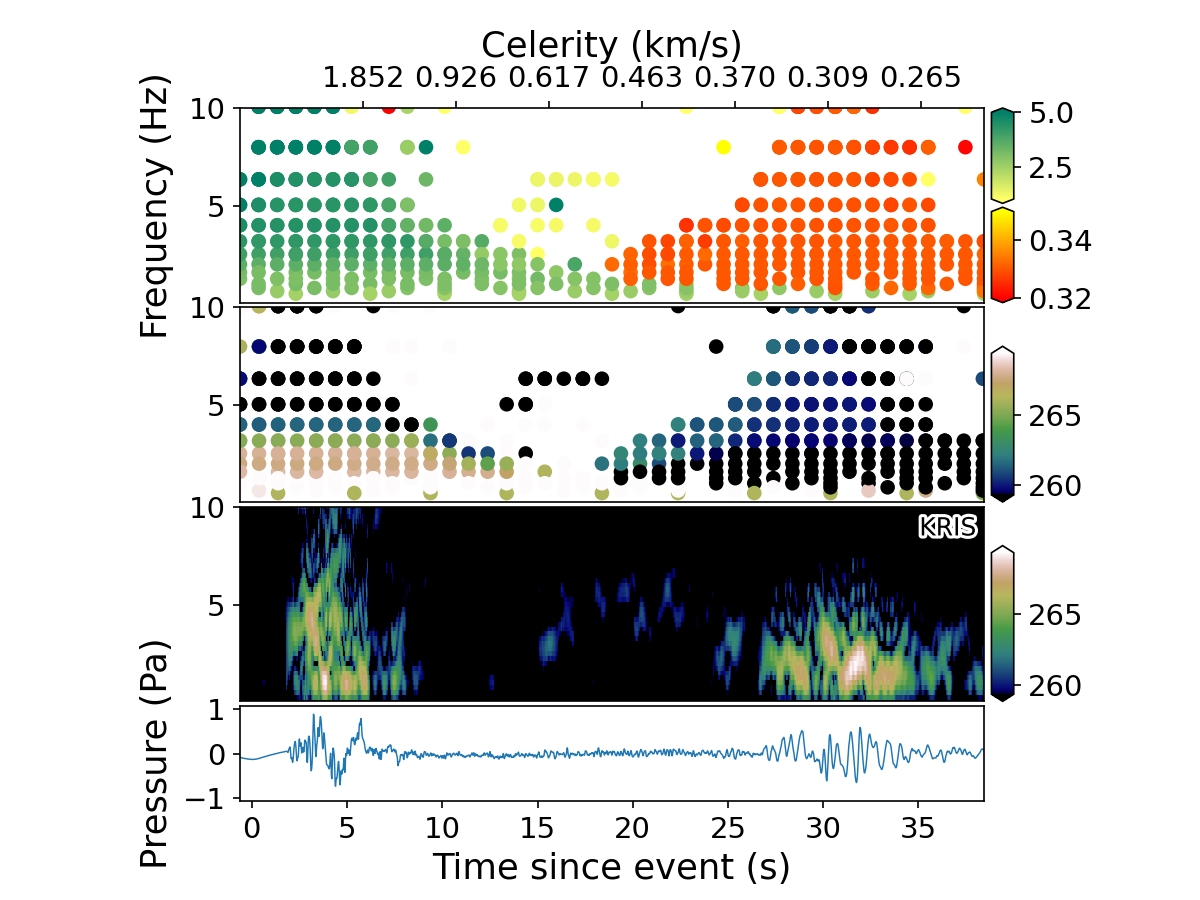

In [26]:
from matplotlib import patheffects
import matplotlib 
# configure backend here
#matplotlib.use('Agg')

def plot_spectro(station, tr_in, data_toplot_all, ev_time, source_loc, freq_min=0.1, freq_max=1, nperseg=10, noverlap=9, nfft=100, vmin_az=250, vmax_az=280, voffset_az=5, fontsize=14., fontsize_ticks=12., add_left_legend=True, add_right_legend=True):
    
    wgs84_geod = Geod(ellps='WGS84')
    _, baz, range_km = wgs84_geod.inv(source_loc[1], source_loc[0], tr_in.stats.longitude, tr_in.stats.latitude)
    baz = baz + 360. if baz < 0 else baz
    
    path_effects = [patheffects.withStroke(linewidth=3, foreground="w")]
    tr = tr_in.copy()
    tr.taper(0.05)
    tr.filter('bandpass', freqmin=freq_min, freqmax=freq_max)
    offset_start = tr.stats.starttime - ev_time
    f, t, Sxx = signal.spectrogram(tr.data, 1./tr.stats.delta, nperseg=nperseg, noverlap=noverlap, nfft=nfft, scaling='spectrum'); 
    Sxx = 10*np.log10(Sxx)
    
    fig = plt.figure(figsize=(8,6))
    h_wave = 1
    h_spec = 2
    grid = fig.add_gridspec(h_spec*3+h_wave, 1)
    axs, axs_cbar = [], []
    
    i = 0
    ax = fig.add_subplot(grid[h_spec*i:h_spec*(i+1),:],)
    axs.append(ax)
    
    two_vel_cbars = True
    vel_threshold = 0.4
    if two_vel_cbars:
        data_toplot_all_loc = data_toplot_all.loc[data_toplot_all.vel>vel_threshold]
        sc = ax.scatter(data_toplot_all_loc.t_abs+offset_start, data_toplot_all_loc.f, c=data_toplot_all_loc.vel, cmap='summer_r', vmin=1., vmax=5.)
        axins = inset_axes(ax, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.01, 0.51, 1, 0.49), bbox_transform=ax.transAxes, borderpad=0)
        axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False, labelsize=fontsize_ticks)
        cbar = plt.colorbar(sc, cax=axins, orientation='vertical', extend='both')
        #cbar.ax.set_ylabel('Seismic vel.\n(km/s)', labelpad=13., fontsize=11.)
        if add_right_legend:
            cbar.ax.set_ylabel('Velocity\n(km/s)', labelpad=15, fontsize=fontsize)
        axs_cbar.append(cbar.ax)
        
        data_toplot_all_loc = data_toplot_all.loc[data_toplot_all.vel<=vel_threshold]
        sc_IS = ax.scatter(data_toplot_all_loc.t_abs+offset_start, data_toplot_all_loc.f, c=data_toplot_all_loc.vel, cmap='autumn', vmin=0.32, vmax=0.35)
        axins = inset_axes(ax, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.01, 0, 1, 0.49), bbox_transform=ax.transAxes, borderpad=0)
        axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False, labelsize=fontsize_ticks)
        cbar_IS = plt.colorbar(sc_IS, cax=axins, orientation='vertical', extend='both')
        axs_cbar.append(cbar_IS.ax)
        
    else:
        sc = ax.scatter(data_toplot_all.t_abs+offset_start, data_toplot_all.f, c=data_toplot_all.vel, cmap='gist_earth', vmax=5.)
        axins = inset_axes(ax, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.01, 0, 1, 0.8), bbox_transform=ax.transAxes, borderpad=0)
        axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        cbar = plt.colorbar(sc, cax=axins, orientation='vertical', extend='both')
        if add_right_legend:
            cbar.ax.set_ylabel('Velocity\n(km/s)', labelpad=3., fontsize=fontsize)
        axs_cbar.append(cbar.ax)
    
    #ax.set_yscale('log')
    #ax.tick_params(axis='both', which='both', labelbottom=False,bottom=False)
    if add_left_legend:
        ax.set_ylabel('Frequency (Hz)', fontsize=fontsize)
    ax.set_ylim([freq_min, freq_max])
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xticks([tick for tick in ax.get_xticks() if not tick == 0])
    #print([tick for tick in ax.get_xticks()])
    ax.set_xlim([data_toplot_all.t_abs.min()+offset_start, data_toplot_all.t_abs.max()+offset_start])
    ticks = ['{:.3f}'.format(range_km*1e-3/float(tick)) for tick in ax.get_xticks()]
    ax.set_xticklabels(ticks)
    ax.set_xlabel('Celerity (km/s)', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize_ticks)
    
    i += 1
    ax = fig.add_subplot(grid[h_spec*i:h_spec*(i+1),:], sharey=ax)
    axs.append(ax)
    options_az = {'vmin': vmin_az, 'vmax': vmax_az}
    if voffset_az > -1:
        options_az['vmin'] = baz-voffset_az
        options_az['vmax'] = baz+voffset_az
    sc = ax.scatter(data_toplot_all.t_abs+offset_start, data_toplot_all.f, c=data_toplot_all.az, cmap='gist_earth', **options_az)
    #ax.set_yscale('log')
    
    axins = inset_axes(ax, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.01, 0, 1, 0.8), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False, labelsize=fontsize_ticks)
    cbar = plt.colorbar(sc, cax=axins, orientation='vertical', extend='both')
    if add_right_legend:
        cbar.ax.set_ylabel('Azimuth', labelpad=11., fontsize=fontsize)
    ax.tick_params(axis='both', which='both', labelbottom=False,bottom=False, labelsize=fontsize_ticks)
    #ax.yaxis.set_ticklabels([])
    ax.set_ylim([freq_min, freq_max])
    ax.set_xlim([data_toplot_all.t_abs.min()+offset_start, data_toplot_all.t_abs.max()+offset_start])
    #ax.yaxis.set_ticklabels([])
    axs_cbar.append(axins)
    
    i += 1
    ax = fig.add_subplot(grid[h_spec*i:h_spec*(i+1),:], sharex=ax, sharey=ax)
    axs.append(ax)
    ax.pcolormesh(t+offset_start, f, Sxx, shading='auto', cmap='gist_earth', vmin=np.quantile(Sxx, q=0.9));
    ax.set_ylim([freq_min, freq_max])
    #ax.yaxis.set_ticklabels([])
    #ax.set_yscale('log')
    ax.tick_params(axis='both', which='both', labelbottom=False,bottom=False, labelsize=fontsize_ticks)
    ax.text(0.99, 0.95, station, fontsize=12., ha='right', va='top', transform = ax.transAxes, path_effects=path_effects)
    axins = inset_axes(ax, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.01, 0, 1, 0.8), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False, labelsize=fontsize_ticks)
    cbar = plt.colorbar(sc, cax=axins, orientation='vertical', extend='both')
    if add_right_legend:
        cbar.ax.set_ylabel('Power\nspectrum (db)', labelpad=11., fontsize=fontsize)
    
    ax = fig.add_subplot(grid[-h_wave:,:], sharex=ax, )
    axs.append(ax)
    ax.plot(tr.times()+offset_start, tr.data, linewidth=0.7); 
    if add_left_legend:
        ax.set_ylabel('Pressure (Pa)', fontsize=fontsize)
    ax.set_xlabel('Time since event (s)', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize_ticks)
    ax.set_xlim([tr.times().min()+offset_start+1, tr.times().max()+offset_start-1])
    coef = 2
    ax.set_ylim([-np.quantile(tr.data,q=0.99)*coef, np.quantile(tr.data,q=0.99)*coef])
    
    fig.subplots_adjust(right=0.82, left=0.2, hspace=0.05)
    fig.align_ylabels(axs)
    
    file_name = f'./figures/Kiruna_data_PMCC_0.5Hz_{tr.stats.station}.pdf'
    fig.savefig(file_name)

ev_time = UTCDateTime(2020, 5, 18, 1, 11, 56)



station = 'KRIS'
dict_legend = dict(add_left_legend=True, add_right_legend=False)
freq_min = 5e-2 # KRIS
freq_max = 10. # KRIS
"""
"""
"""
station = 'IS37'
dict_legend = dict(add_left_legend=False, add_right_legend=False)
freq_min = 0.5 # ARCES & I37
freq_max = 5. # ARCES & I37
"""

"""
station = 'ARCI'
dict_legend = dict(add_left_legend=False, add_right_legend=True)
freq_min = 0.5 # ARCES & I37
freq_max = 5. # ARCES & I37
"""
plot_spectro(station, beam, data_toplot_all, ev_time, source_loc, freq_min=freq_min, freq_max=freq_max, nperseg=40, noverlap=39, nfft=200, vmin_az=0, vmax_az=360, fontsize=17., fontsize_ticks=14., **dict_legend)